# Time Series Forecasting with Machine Learning 

In [89]:
import pandas as pd
import numpy as np 
import seaborn as sns
color_pal = sns.color_palette()
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import xgboost as xgb
from sklearn.metrics import mean_squared_error


In [90]:
df = pd.read_csv('PJME_hourly.csv')

### Set Index as Datetime
df = df.set_index('Datetime')

#Change Datetime Datatype to Datetime
df.index = pd.to_datetime(df.index)

## Data Exploration & Cleaning

In [91]:
df

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0


In [92]:
df.shape

(145366, 1)

In [93]:
df.dtypes

PJME_MW    float64
dtype: object

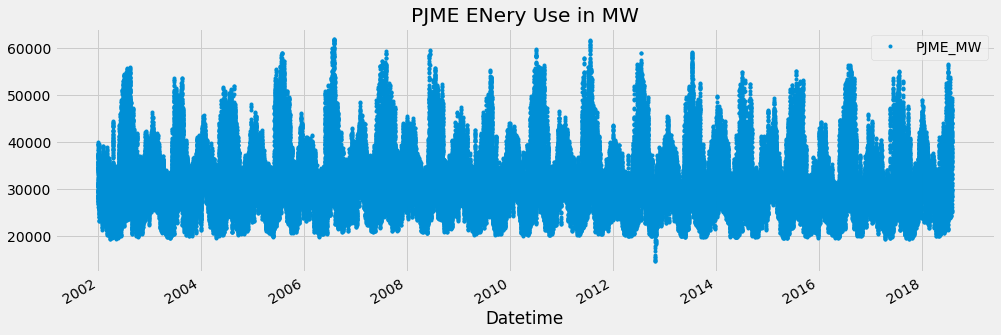

In [94]:
df.plot(style = '.', 
        figsize = (15, 5), 
        color = color_pal[0], 
        title = 'PJME ENery Use in MW');

## Train/Test Split

Our data will be split in 2 sets. prior to Januray 2015 will be in the train set and the data after Janurary 2015 will be in our test set.

In [95]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

### Plot both train and test split 

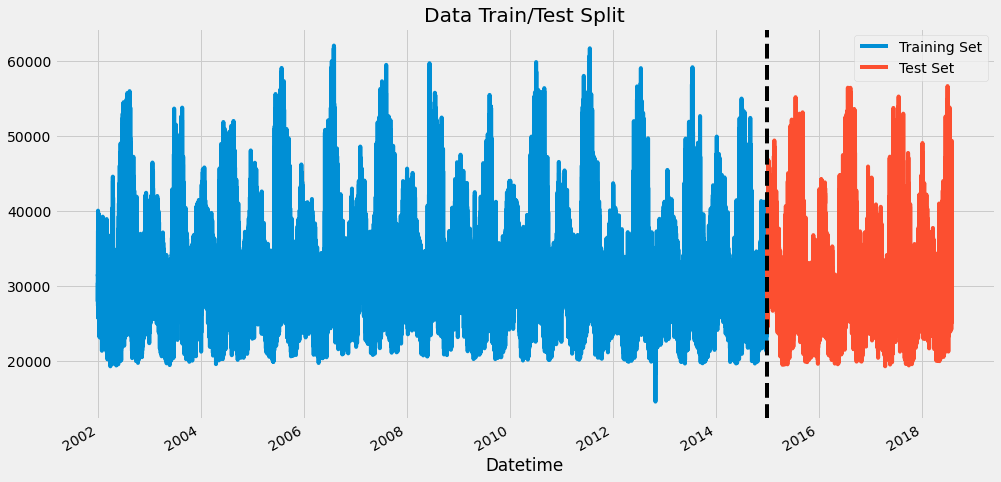

In [96]:
fig, ax = plt.subplots(figsize = (15,8))
train.plot(ax = ax, label= 'Training Set', title = 'Data Train/Test Split')
test.plot(ax = ax, label= 'Test Set')
ax.axvline('01-01-2015', color='black', ls = '--')
ax.legend(['Training Set', 'Test Set']);

### How Does 1 Single week of data looks like?

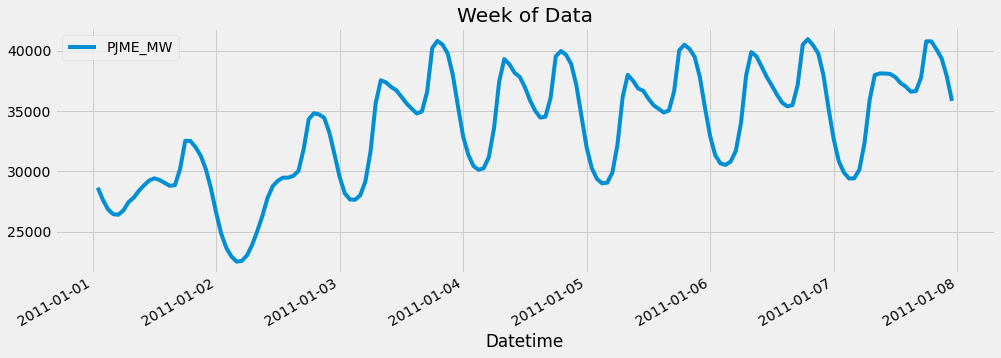

In [97]:
df.loc[(df.index > '01-01-2011') & (df.index < '01-08-2011')] \
.plot(figsize=(15, 5), title='Week of Data');

### Feature Creation

In [98]:
def create_features(df):
    """
    Create time series features based on time series index. 
    """
    df.copy()
    df['Hour'] = df.index.hour
    df['Day_of_Week'] = df.index.dayofweek
    df['Quarter'] = df.index.quarter
    df['Month'] =  df.index.month
    df['Year'] = df.index.year
    df['Day_of_Year'] = df.index.dayofyear
    return df

In [99]:
df = create_features(df)

In [100]:
df

,PJME_MW,Hour,Day_of_Week,Quarter,Month,Year,Day_of_Year
Datetime,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365
...,...,...,...,...,...,...,...
2018-01-01 20:00:00,44284.0,20,0,1,1,2018,1
2018-01-01 21:00:00,43751.0,21,0,1,1,2018,1
2018-01-01 22:00:00,42402.0,22,0,1,1,2018,1


in 'day_of_week' Monday is 0 and Sunday is 6

## Visualize relationship features/Target 

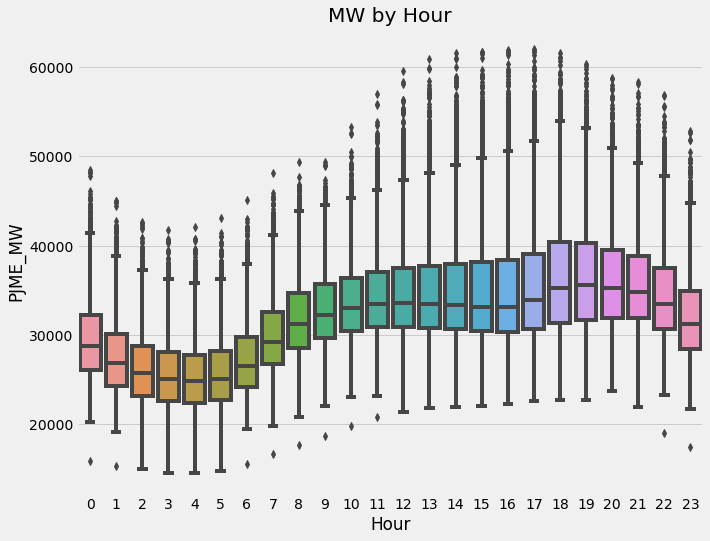

In [101]:
fig, ax= plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='Hour', y='PJME_MW')
ax.set_title('MW by Hour');

The box plot shows that early in the mornign, there is a deep in a consumption of energy used, where the consumption picks up from 6am

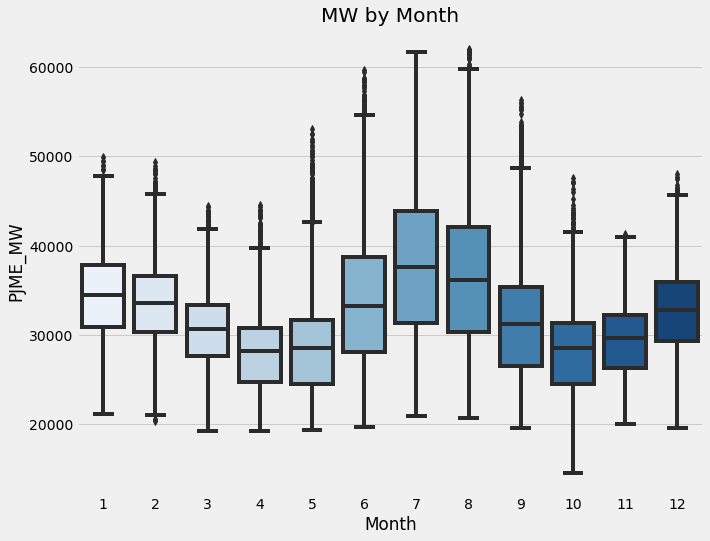

In [102]:
fig, ax= plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='Month', y='PJME_MW', palette='Blues')
ax.set_title('MW by Month');

The peak month tends to be in summer season and specifically in July, where i assume is due to the fact that more ACs are operating

## Model Creation

In [103]:
###run the train and test sets through create fetures function
train = create_features(train)
test = create_features(test)


### Define the features
FEATURES = ['Hour', 'Day_of_Week', 'Quarter', 'Month', 'Year','Day_of_Year']
TARGET = 'PJME_MW'

<ipython-input-98-2146c3615582>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Hour'] = df.index.hour
<ipython-input-98-2146c3615582>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Day_of_Week'] = df.index.dayofweek
<ipython-input-98-2146c3615582>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

In [104]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [105]:
reg = xgb.XGBRegressor(n_estimators = 1000, 
                       early_Stopping_rounds=50, 
                       learning_rate = 0.01)

reg.fit(X_train, y_train,
       eval_set = [(X_train, y_train), (X_test, y_test)],
       verbose = True)

[20:46:12] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "early_Stopping_rounds" } are not used.

[0]	validation_0-rmse:32601.87826	validation_1-rmse:31654.28935
[1]	validation_0-rmse:32279.88735	validation_1-rmse:31332.60350
[2]	validation_0-rmse:31961.14360	validation_1-rmse:31014.27357
[3]	validation_0-rmse:31645.62525	validation_1-rmse:30699.10021
[4]	validation_0-rmse:31333.30788	validation_1-rmse:30385.92606
[5]	validation_0-rmse:31024.14316	validation_1-rmse:30075.82644
[6]	validation_0-rmse:30718.10796	validation_1-rmse:29769.05547
[7]	validation_0-rmse:30415.17979	validation_1-rmse:29465.13991
[8]	validation_0-rmse:30115.31200	validation_1-rmse:29164.62813
[9]	validation_0-rmse:29818.48171	validation_1-rmse:28866.85195
[10]	validation_0-rmse:29524.66621	validation_1-rmse:28571.74321
[11]	validation_0-rmse:29233.82326	validation_1-rmse:28280.36822
[12]	validation_0-rmse:28945.84624	validation_1-rmse:27991.28725
[13]	valid

[124]	validation_0-rmse:9901.97263	validation_1-rmse:9193.70836
[125]	validation_0-rmse:9813.44294	validation_1-rmse:9108.32514
[126]	validation_0-rmse:9725.99293	validation_1-rmse:9024.42487
[127]	validation_0-rmse:9639.34517	validation_1-rmse:8943.22685
[128]	validation_0-rmse:9553.83381	validation_1-rmse:8860.74829
[129]	validation_0-rmse:9468.90731	validation_1-rmse:8783.77605
[130]	validation_0-rmse:9385.18620	validation_1-rmse:8702.78904
[131]	validation_0-rmse:9302.13036	validation_1-rmse:8628.24670
[132]	validation_0-rmse:9219.96985	validation_1-rmse:8553.50065
[133]	validation_0-rmse:9139.05976	validation_1-rmse:8475.63618
[134]	validation_0-rmse:9058.77815	validation_1-rmse:8401.78999
[135]	validation_0-rmse:8979.33354	validation_1-rmse:8329.68884
[136]	validation_0-rmse:8900.82328	validation_1-rmse:8257.61035
[137]	validation_0-rmse:8823.16493	validation_1-rmse:8187.47943
[138]	validation_0-rmse:8746.40369	validation_1-rmse:8117.30033
[139]	validation_0-rmse:8670.69319	valid

[253]	validation_0-rmse:3979.26711	validation_1-rmse:4156.98464
[254]	validation_0-rmse:3961.00890	validation_1-rmse:4147.81765
[255]	validation_0-rmse:3944.25600	validation_1-rmse:4137.13969
[256]	validation_0-rmse:3927.56280	validation_1-rmse:4126.40487
[257]	validation_0-rmse:3909.69820	validation_1-rmse:4116.66382
[258]	validation_0-rmse:3893.02728	validation_1-rmse:4105.37452
[259]	validation_0-rmse:3877.19328	validation_1-rmse:4095.87654
[260]	validation_0-rmse:3860.91496	validation_1-rmse:4086.11364
[261]	validation_0-rmse:3844.68215	validation_1-rmse:4075.07671
[262]	validation_0-rmse:3829.43135	validation_1-rmse:4066.33859
[263]	validation_0-rmse:3813.64350	validation_1-rmse:4056.79027
[264]	validation_0-rmse:3798.97077	validation_1-rmse:4048.14058
[265]	validation_0-rmse:3782.79682	validation_1-rmse:4039.45958
[266]	validation_0-rmse:3767.96005	validation_1-rmse:4030.05158
[267]	validation_0-rmse:3753.73564	validation_1-rmse:4021.88378
[268]	validation_0-rmse:3739.05516	valid

[382]	validation_0-rmse:2938.77172	validation_1-rmse:3718.66917
[383]	validation_0-rmse:2936.59209	validation_1-rmse:3717.97607
[384]	validation_0-rmse:2934.44654	validation_1-rmse:3717.32109
[385]	validation_0-rmse:2930.45197	validation_1-rmse:3717.54549
[386]	validation_0-rmse:2928.40947	validation_1-rmse:3716.98411
[387]	validation_0-rmse:2924.75154	validation_1-rmse:3717.23919
[388]	validation_0-rmse:2922.74662	validation_1-rmse:3716.75390
[389]	validation_0-rmse:2918.65801	validation_1-rmse:3717.04523
[390]	validation_0-rmse:2914.96604	validation_1-rmse:3717.22400
[391]	validation_0-rmse:2913.07012	validation_1-rmse:3716.73675
[392]	validation_0-rmse:2909.27608	validation_1-rmse:3717.36197
[393]	validation_0-rmse:2906.62094	validation_1-rmse:3717.37200
[394]	validation_0-rmse:2903.57242	validation_1-rmse:3717.49762
[395]	validation_0-rmse:2900.99520	validation_1-rmse:3717.56557
[396]	validation_0-rmse:2896.24892	validation_1-rmse:3716.95968
[397]	validation_0-rmse:2894.50112	valid

[511]	validation_0-rmse:2685.33976	validation_1-rmse:3758.95840
[512]	validation_0-rmse:2683.23445	validation_1-rmse:3759.06741
[513]	validation_0-rmse:2681.73933	validation_1-rmse:3761.06843
[514]	validation_0-rmse:2681.29073	validation_1-rmse:3761.85928
[515]	validation_0-rmse:2679.25535	validation_1-rmse:3761.85919
[516]	validation_0-rmse:2677.79470	validation_1-rmse:3763.84457
[517]	validation_0-rmse:2676.73697	validation_1-rmse:3763.91292
[518]	validation_0-rmse:2676.21927	validation_1-rmse:3763.84321
[519]	validation_0-rmse:2675.87245	validation_1-rmse:3763.96028
[520]	validation_0-rmse:2674.35090	validation_1-rmse:3765.94772
[521]	validation_0-rmse:2672.39430	validation_1-rmse:3766.05698
[522]	validation_0-rmse:2672.06553	validation_1-rmse:3766.22122
[523]	validation_0-rmse:2670.58030	validation_1-rmse:3768.19776
[524]	validation_0-rmse:2669.21990	validation_1-rmse:3768.92324
[525]	validation_0-rmse:2667.85950	validation_1-rmse:3770.94637
[526]	validation_0-rmse:2666.52841	valid

[640]	validation_0-rmse:2564.19896	validation_1-rmse:3831.05431
[641]	validation_0-rmse:2563.55253	validation_1-rmse:3831.25737
[642]	validation_0-rmse:2562.73130	validation_1-rmse:3832.36146
[643]	validation_0-rmse:2562.53794	validation_1-rmse:3832.73833
[644]	validation_0-rmse:2562.16996	validation_1-rmse:3832.74310
[645]	validation_0-rmse:2561.63326	validation_1-rmse:3833.25978
[646]	validation_0-rmse:2559.69530	validation_1-rmse:3833.28101
[647]	validation_0-rmse:2559.33520	validation_1-rmse:3833.32028
[648]	validation_0-rmse:2559.16024	validation_1-rmse:3833.32171
[649]	validation_0-rmse:2557.24996	validation_1-rmse:3833.34388
[650]	validation_0-rmse:2556.57519	validation_1-rmse:3833.45048
[651]	validation_0-rmse:2555.95401	validation_1-rmse:3833.65347
[652]	validation_0-rmse:2555.28766	validation_1-rmse:3833.66969
[653]	validation_0-rmse:2554.93828	validation_1-rmse:3833.69214
[654]	validation_0-rmse:2554.17573	validation_1-rmse:3833.89626
[655]	validation_0-rmse:2553.27117	valid

[769]	validation_0-rmse:2480.23838	validation_1-rmse:3872.78160
[770]	validation_0-rmse:2478.28850	validation_1-rmse:3873.16439
[771]	validation_0-rmse:2478.13503	validation_1-rmse:3873.14095
[772]	validation_0-rmse:2477.22468	validation_1-rmse:3873.12224
[773]	validation_0-rmse:2476.53969	validation_1-rmse:3873.61737
[774]	validation_0-rmse:2474.85728	validation_1-rmse:3873.59580
[775]	validation_0-rmse:2473.90179	validation_1-rmse:3874.41994
[776]	validation_0-rmse:2473.74900	validation_1-rmse:3874.38880
[777]	validation_0-rmse:2473.64608	validation_1-rmse:3874.46104
[778]	validation_0-rmse:2471.92597	validation_1-rmse:3874.71179
[779]	validation_0-rmse:2471.10334	validation_1-rmse:3875.79804
[780]	validation_0-rmse:2470.67651	validation_1-rmse:3875.85766
[781]	validation_0-rmse:2470.53033	validation_1-rmse:3875.83454
[782]	validation_0-rmse:2468.95785	validation_1-rmse:3875.81356
[783]	validation_0-rmse:2468.08902	validation_1-rmse:3876.86001
[784]	validation_0-rmse:2467.77356	valid

[898]	validation_0-rmse:2406.94366	validation_1-rmse:3902.22831
[899]	validation_0-rmse:2406.38923	validation_1-rmse:3902.49124
[900]	validation_0-rmse:2405.19157	validation_1-rmse:3902.94473
[901]	validation_0-rmse:2405.00025	validation_1-rmse:3903.38294
[902]	validation_0-rmse:2404.75865	validation_1-rmse:3903.27790
[903]	validation_0-rmse:2404.65652	validation_1-rmse:3903.28926
[904]	validation_0-rmse:2404.44354	validation_1-rmse:3903.41588
[905]	validation_0-rmse:2402.95544	validation_1-rmse:3903.39270
[906]	validation_0-rmse:2401.75619	validation_1-rmse:3904.76395
[907]	validation_0-rmse:2401.27927	validation_1-rmse:3904.89005
[908]	validation_0-rmse:2401.05509	validation_1-rmse:3905.11536
[909]	validation_0-rmse:2400.84647	validation_1-rmse:3905.24042
[910]	validation_0-rmse:2400.51915	validation_1-rmse:3905.14719
[911]	validation_0-rmse:2400.33428	validation_1-rmse:3905.58355
[912]	validation_0-rmse:2399.85583	validation_1-rmse:3905.63085
[913]	validation_0-rmse:2399.64707	valid

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_Stopping_rounds=50,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)

## Feature Importance

the important values on how much the features werre used in each of the trees in the model

In [107]:
reg.feature_importances_

array([0.4252445 , 0.11189683, 0.046836  , 0.2702518 , 0.0274494 ,
       0.11832149], dtype=float32)

### create a dataframe on these features

In [109]:
FI = pd.DataFrame(data = reg.feature_importances_,
            index = reg.feature_names_in_,
            columns=['importance'])

In [110]:
FI

,importance
Hour,0.425245
Day_of_Week,0.111897
Quarter,0.046836
Month,0.270252
Year,0.027449
Day_of_Year,0.118321


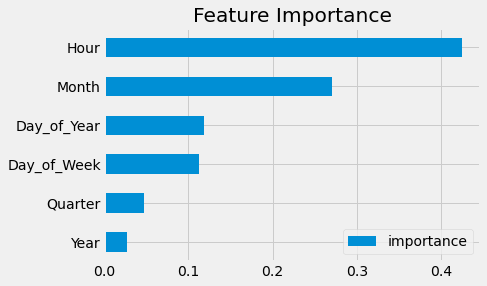

In [112]:
FI.sort_values('importance').plot(kind = 'barh', title = 'Feature Importance');

## Forecast on Test Set

In [114]:
test['predictions'] = reg.predict(X_test)

<ipython-input-114-ab8619334f1a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predictions'] = reg.predict(X_test)


### Merge the test set predictions with the original dataframe

In [118]:
df = df.merge(test[['predictions']], how = 'left', left_index = True, right_index = True)

In [119]:
df

,PJME_MW,Hour,Day_of_Week,Quarter,Month,Year,Day_of_Year,predictions
Datetime,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,NaN
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,NaN
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,NaN
...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,39905.632812
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,38927.718750
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,37956.136719


### Plot the new dataframe

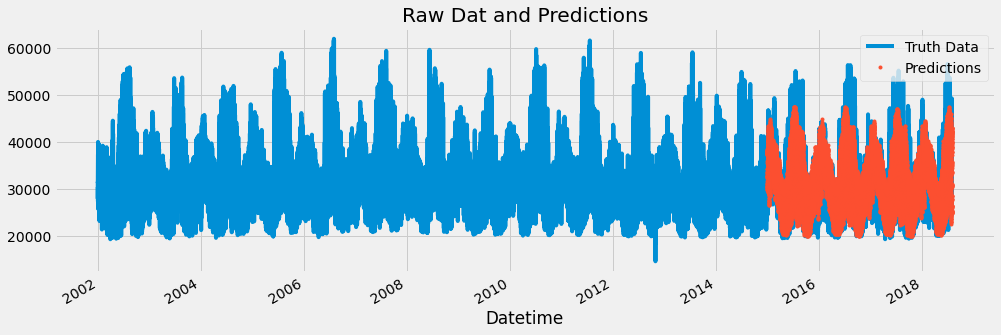

In [120]:
ax = df[['PJME_MW']].plot(figsize = (15,5))
df['predictions'].plot(ax = ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Predictions')
plt.show()

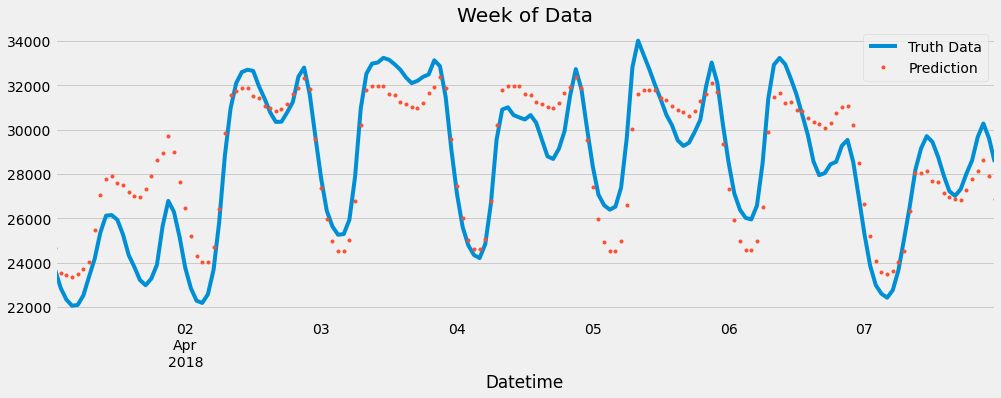

In [122]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['predictions'] \
    .plot(style = '.')
plt.legend(['Truth Data', 'Prediction'])
plt.show()


It looks as our model has predicted the trend but overall it didn't predict well. A better parameter tunning can imporve the prediction. 

We can also add more feature for specific days of the year such as holidays and weekends.
Another feature to add is the weather forcast

### Evaluation Metric

In [132]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['predictions']))
print(f'RMSE score on the test set: {score:0.2f}')

RMSE score on the test set: 3931.65


### Calculate Error

### Which days were the worst days in our predictions

In [136]:
test['error'] = np.abs(test[TARGET] - test['predictions'])

<ipython-input-136-294cfaac077a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['error'] = np.abs(test[TARGET] - test['predictions'])


In [138]:
test['date'] = test.index.date

<ipython-input-138-f26c019bf92f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['date'] = test.index.date


In [141]:
test.groupby('date')['error'].mean().sort_values(ascending = False).head()

date
2016-08-13    15537.904704
2016-08-14    15510.595785
2016-08-12    12351.800781
2016-09-10    12161.702555
2016-09-09    10960.880778
Name: error, dtype: float64

### Which days were the best days in our predictions

In [143]:
test.groupby('date')['error'].mean().sort_values(ascending = True).head()

date
2016-10-02    316.921387
2017-04-01    370.710531
2015-10-28    373.086263
2016-10-08    374.116048
2017-08-11    376.370524
Name: error, dtype: float64